# Module 3: The Limits of Rules & The Promise of Learning

## Welcome to Module 3!

In our last module, we mastered the Canny edge detector—a powerful, rule-based algorithm for finding structure in images. We saw how effective it can be on clean, simple images. But what happens when we face the complexity and messiness of the real world?

**Our Story for this Module:** We will push our classical, rule-based methods to their breaking point. We will discover where algorithms like Canny fail and understand *why* they fail. This critical understanding will build the motivation for a completely new paradigm: instead of us writing the rules, we will build a system that can **learn the rules for itself**.

### **Setup: Importing Libraries & Loading Assets**

Let's import our standard libraries and prepare some challenging images to test our Canny edge detector.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Helper function to display images
def display_image(title, image, is_bgr=True):
    if is_bgr:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image
    plt.imshow(image_rgb, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load our challenging images from the assets folder
textured_lizard_path = '../assets/lizard.jpg'
# Assuming you have an image with poor lighting in the assets folder
poor_lighting_path = '../assets/poor_lighting.jpg'

lizard_img = cv2.imread(textured_lizard_path)
lighting_img = cv2.imread(poor_lighting_path)

if lizard_img is None:
    print(f"Error loading image: {textured_lizard_path}")
if lighting_img is None:
    print(f"Error loading image: {poor_lighting_path}")
else:
    print("Libraries imported and images loaded successfully!")

Libraries imported and images loaded successfully!


---

## **Part 1: Breaking the Canny Edge Detector**

The Canny algorithm relies on finding sharp changes in pixel intensity. But what happens when the image doesn't have clean, sharp edges?

### **Challenge 1: Complex Textures**

Let's use the image of the lizard, which has a lot of fine-grained texture from its scales. We'll apply the blur + Canny pipeline we learned in the last module.

Processing Canny edges...
Processing contours...


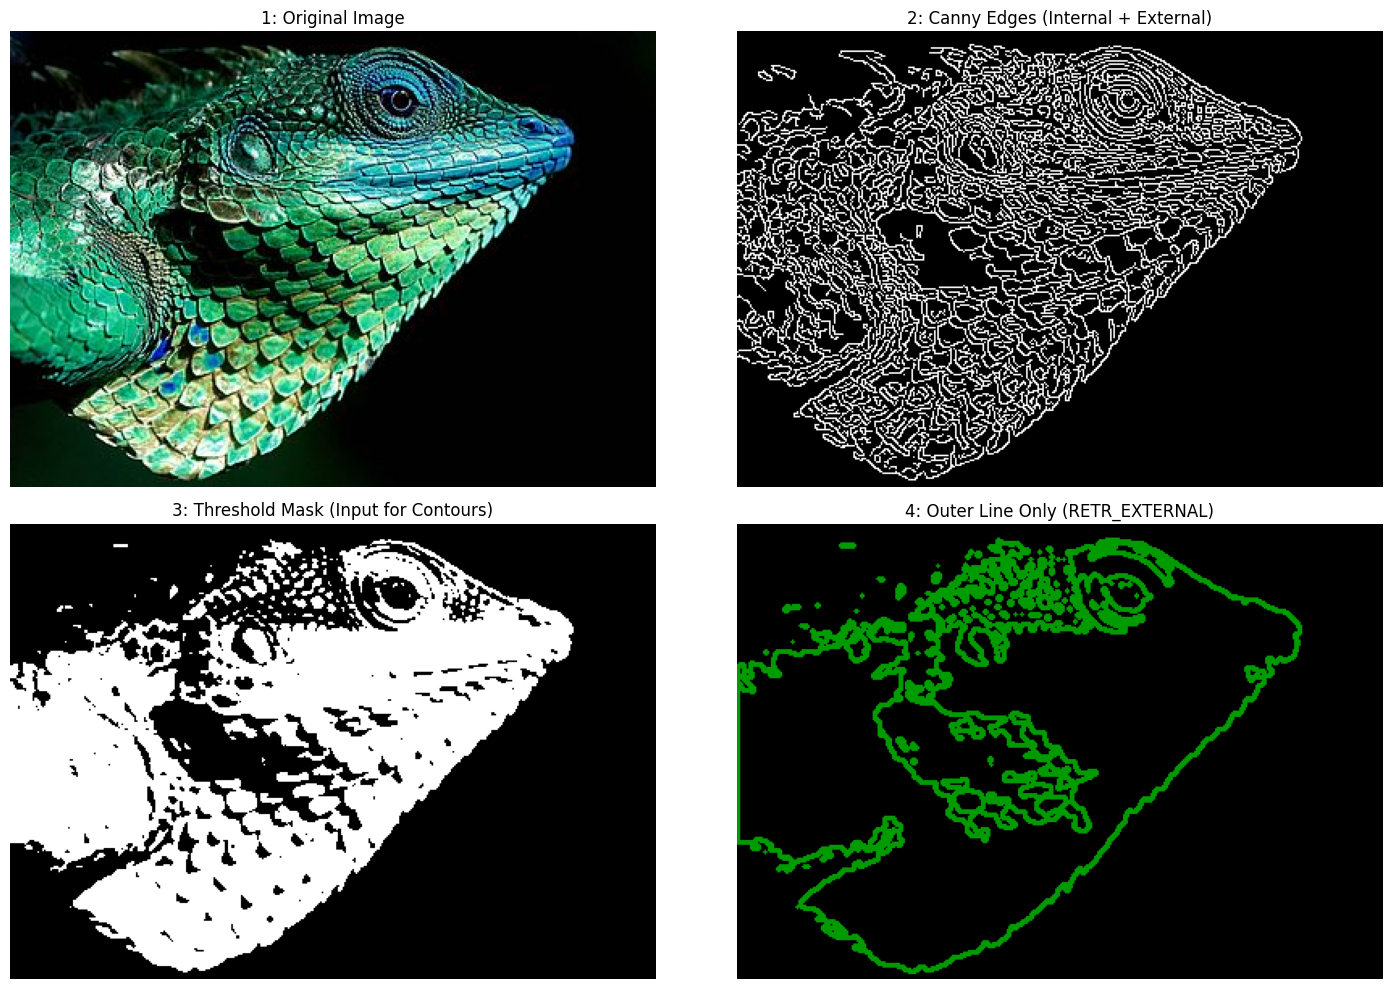

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

try:
    lizard_img
except NameError:
    print("lizard_img not found, creating a placeholder image.")
    lizard_img = np.zeros((400, 600, 3), dtype=np.uint8)
    cv2.rectangle(lizard_img, (100, 100), (500, 300), (255, 255, 255), -1)
    cv2.rectangle(lizard_img, (150, 150), (250, 250), (50, 50, 50), -1) 

print("Processing Canny edges...")
gray_lizard = cv2.cvtColor(lizard_img, cv2.COLOR_BGR2GRAY)
blurred_lizard = cv2.GaussianBlur(gray_lizard, (5, 5), 0)
lizard_edges = cv2.Canny(blurred_lizard, 50, 150)

print("Processing contours...")
ret, thresh = cv2.threshold(blurred_lizard, 0, 255, 
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 2: Find contours, getting ONLY external ones
contours, hierarchy = cv2.findContours(thresh, 
                                       cv2.RETR_EXTERNAL, 
                                       cv2.CHAIN_APPROX_SIMPLE)

contour_img = np.zeros_like(lizard_img)
cv2.drawContours(contour_img, contours, -1, (0, 155, 0), 2) 

plt.figure(figsize=(15, 10))

# Plot 1: Original
plt.subplot(2, 2, 1)
plt.imshow(lizard_img)
plt.title("1: Original Image")
plt.axis('off')

# Plot 2: Canny Edges (The problem: too much detail)
plt.subplot(2, 2, 2)
plt.imshow(lizard_edges, cmap='gray')
plt.title("2: Canny Edges (Internal + External)")
plt.axis('off')

# Plot 3: The Threshold "Mask" (The intermediate step)
plt.subplot(2, 2, 3)
plt.imshow(thresh, cmap='gray')
plt.title("3: Threshold Mask (Input for Contours)")
plt.axis('off')

# Plot 4: The Final Result
plt.subplot(2, 2, 4)
plt.imshow(contour_img)
plt.title("4: Outer Line Only (RETR_EXTERNAL)")
plt.axis('off')

plt.tight_layout()
plt.show()

Processing the lizard image...


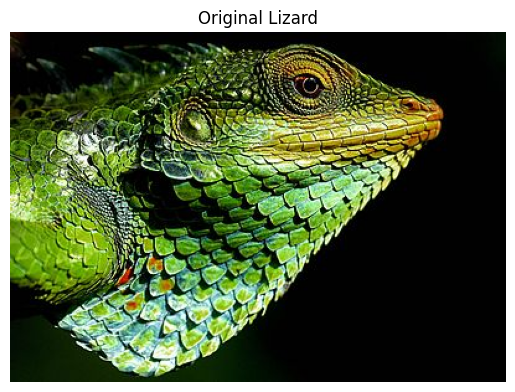

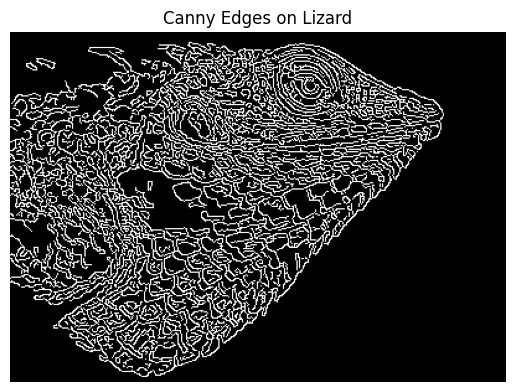

In [6]:
print("Processing the lizard image...")
gray_lizard = cv2.cvtColor(lizard_img, cv2.COLOR_BGR2GRAY)
blurred_lizard = cv2.GaussianBlur(gray_lizard, (5, 5), 0)
lizard_edges = cv2.Canny(blurred_lizard, 50, 150)

display_image("Original Lizard", lizard_img)
display_image("Canny Edges on Lizard", lizard_edges, is_bgr=False)

Creating threshold mask...
Cleaning the mask...
Getting outer line...


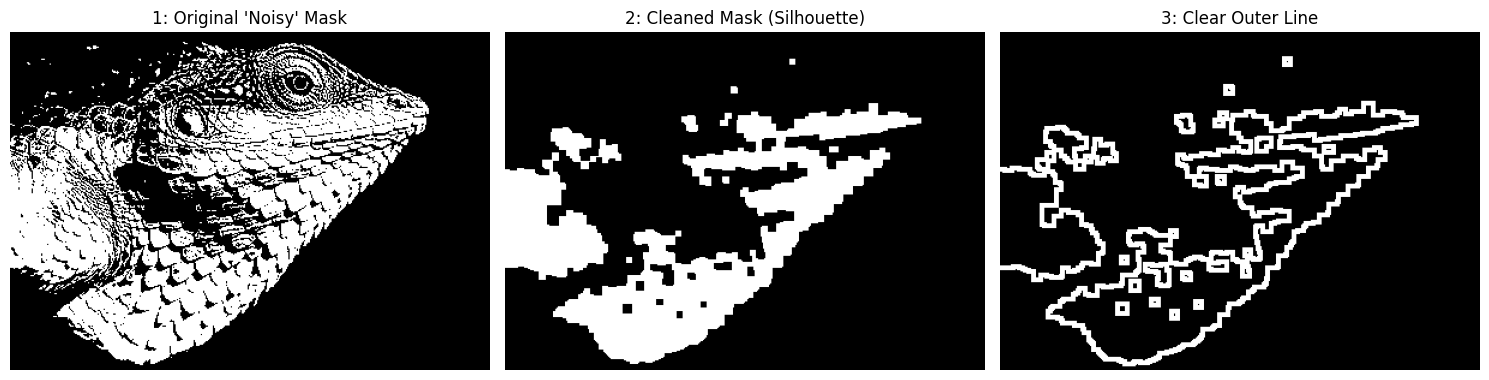

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Original Image ---
# Assume lizard_img is loaded and is BGR
try:
    lizard_img
except NameError:
    print("lizard_img not found, creating a placeholder image.")
    lizard_img = np.zeros((400, 600, 3), dtype=np.uint8)
    cv2.rectangle(lizard_img, (100, 100), (500, 300), (255, 255, 255), -1) # Main body
    # Add some noise to the mask
    cv2.circle(lizard_img, (550, 50), (10), (255, 255, 255), -1) # "noise speckle"
    cv2.circle(lizard_img, (200, 200), (20), (0, 0, 0), -1) # "hole"

# --- 2. Create the Basic Threshold Mask ---
print("Creating threshold mask...")
gray_lizard = cv2.cvtColor(lizard_img, cv2.COLOR_BGR2GRAY)
ret, thresh_mask = cv2.threshold(gray_lizard, 0, 255, 
                                 cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# --- 3. "Clean" the Mask (This is the key step) ---
print("Cleaning the mask...")
# Define a kernel
kernel = np.ones((5, 5), np.uint8)

# 1. Remove small white noise specks (Opening)
clean_mask = cv2.morphologyEx(thresh_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# 2. Fill small black holes in the main object (Closing)
# This gives you a solid, clean silhouette
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# --- 4. Get the "Outer Line" from the Clean Mask ---
print("Getting outer line...")
# Use the morphological gradient on the CLEAN mask
outer_line = cv2.morphologyEx(clean_mask, cv2.MORPH_GRADIENT, kernel)

# --- 5. Display the Steps ---
plt.figure(figsize=(15, 8))

# Plot 1: The Original (Noisy) Mask
plt.subplot(1, 3, 1)
plt.imshow(thresh_mask, cmap='gray')
plt.title("1: Original 'Noisy' Mask")
plt.axis('off')

# Plot 2: The "Cleaned" Mask
plt.subplot(1, 3, 2)
plt.imshow(clean_mask, cmap='gray')
plt.title("2: Cleaned Mask (Silhouette)")
plt.axis('off')

# Plot 3: The Final "Clear" Outer Line
plt.subplot(1, 3, 3)
plt.imshow(outer_line, cmap='gray')
plt.title("3: Clear Outer Line")
plt.axis('off')

plt.tight_layout()
plt.show()

#### **Analysis:**

The result is a mess! The Canny detector has picked up on all the tiny edges created by the lizard's scales. For the algorithm, these are valid edges just like the main outline of the lizard's body. We've captured the *texture*, but we've completely lost the *structure* of the main object. We could try blurring more, but that would risk losing the actual outline of the lizard.

### **Challenge 2: Poor and Uneven Lighting**

Now let's try an image where the lighting is poor and creates a lot of shadows. The edges are not defined by sharp lines, but by gradual changes in brightness.

Processing the low-light image...


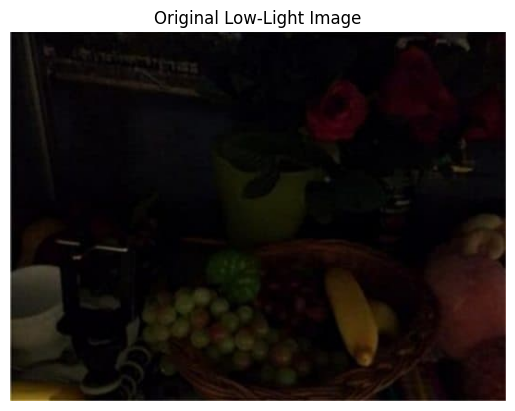

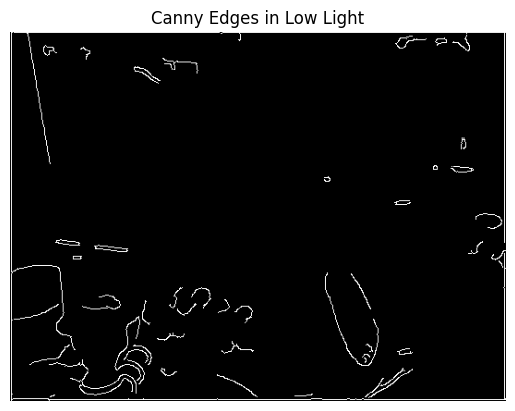

In [3]:
print("Processing the low-light image...")
gray_lighting = cv2.cvtColor(lighting_img, cv2.COLOR_BGR2GRAY)
blurred_lighting = cv2.GaussianBlur(gray_lighting, (5, 5), 0)
lighting_edges = cv2.Canny(blurred_lighting, 30, 70)

display_image("Original Low-Light Image", lighting_img)
display_image("Canny Edges in Low Light", lighting_edges, is_bgr=False)

---

### ⭐ You Try It! - Experiment with - try to get the better results

Use all the learnings we have covered so far and try to get a better result, eg brightness, sharping etc.

In [ ]:
# please add your code here

---

#### **Analysis:**

Again, the results are poor. The edges are broken and incomplete. The gradual shadows don't create a strong enough intensity gradient to pass the Canny thresholds consistently. We could lower the thresholds, but that would just introduce more noise from the background.

**The core problem is clear: We cannot hand-craft a single set of rules (or thresholds) that works for all the variations of the real world.**

---

## **Part 2: The Promise of Learning - A New Paradigm**

What if, instead of us trying to find the perfect kernel or the perfect thresholds, we could build a system that *learns* them from data?

This is the fundamental idea behind **Deep Learning** and **Convolutional Neural Networks (CNNs)**.

### **What is a Convolutional Neural Network (CNN)?**

A CNN is a type of neural network specifically designed for processing grid-like data, like images. Remember our convolution operation from Module 2? A CNN is essentially a stack of convolution layers where the **kernels are not pre-defined by us, but are instead learned during training**.

**How it learns:**
1.  **Hierarchy of Features:** The first layers learn to detect very simple features, like simple edges, corners, and color blobs.
2.  **Building Complexity:** The outputs of these simple feature detectors are then fed into deeper layers, which learn to combine them into more complex features, like eyes, noses, or textures.
3.  **Final Recognition:** Even deeper layers combine these complex features to recognize whole objects, like faces, cats, or cars.

Instead of one hand-crafted "edge detector," a CNN learns *hundreds* of different feature detectors, each optimized for the specific task it's being trained on. It learns that the texture of a lizard's scales is different from the structural edge of its body.

## **Conclusion: The Bridge to Day 2**

We have reached the limit of what classical, rule-based computer vision can easily do. We've seen that while powerful, these methods are brittle and require careful, manual tuning for every new problem.

The challenges we faced today—handling texture, lighting, and complexity—are exactly the problems that deep learning is designed to solve. We have built the motivation for a new approach.

**In our next module,** we will stop writing the rules. We will build our first Convolutional Neural Network from scratch and train it to learn to see all by itself.